# Simulation study

In order to test whether hierarchical approaches are suited to recover parameters if they are applied to models that are an adequate description of the reality, we take the following steps to create artificial data

1. Simulate data from a deterministic process with a structured source of uncertainty
2. Add white noise to the data
3. Mask random fractions of the data and recover parameters
4. Mask systematic fractions of the data according to sparsity assumptions of experimental design and recover parameters
5. Compare the results

In [1]:
import os
from matplotlib import pyplot as plt
from hierarchical_molecular_tktd.sim import NomixHierarchicalSimulation

if os.path.basename(os.getcwd()) != "hierarchical_molecular_tktd":
    os.chdir("..")

We use the hierarchical model that has been identified as the best compromise between degrees of freedom and constraints to converge on the 

In [2]:

sim = NomixHierarchicalSimulation(config="scenarios/simulation_study_v2_informed_masked/settings.cfg")
sim.setup()

/home/flo-schu/projects/pymob/pymob/sim/parameters.py:126: UserWarning: The distribution 'deterministic' is not part of the scipy distributions implemented in pymob. This can lead to inconsistent behavior. It is recommended to use the scipy distribution protocol where possible. https://docs.scipy.org/doc/scipy/reference/stats.html It may also be possible that your distribution has not yet been introduced into the pymob package 
  warnings.warn(


MinMaxScaler(variable=cint, min=1e-08, max=6582.763087754983)
MinMaxScaler(variable=nrf2, min=0.6215531717356583, max=3.806557074337876)
MinMaxScaler(variable=survival, min=0.0, max=18.0)
Results directory exists at '/home/flo-schu/projects/hierarchical_tktd/case_studies/hierarchical_molecular_tktd/results/simulation_study_v2_informed_masked'.
Scenario directory exists at '/home/flo-schu/projects/hierarchical_tktd/case_studies/hierarchical_molecular_tktd/scenarios/simulation_study_v2_informed_masked'.


## Simulating noise in the experimental structure

In order to make our case, we assume that the nominal concentrations are the true concentrations.

Text(0.5, 0, 'Treatment')

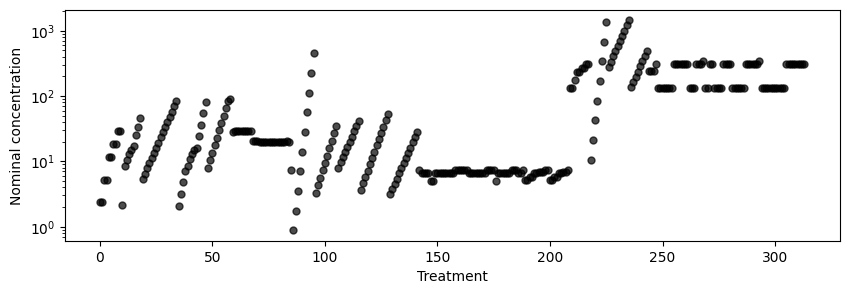

In [3]:

from pymob.utils.plot_helpers import plot_loghist
ce_nom = sim.observations.cext_nom

fig, ax = plt.subplots(1,1, figsize=(10,3))
ax.plot(ce_nom, ls="", marker="o", color="black", alpha=.7, ms=5)
ax.set_yscale("log")
ax.set_ylabel("Nominal concentration")
ax.set_xlabel("Treatment")

We add a structured source of uncertainty on the observations, assuming that the stock solutions of the treatment solutions used in the experiment are deviating systematically (due to weigh in issues, but within the experiments there is no error)

Text(0, 0.5, 'Probability density')

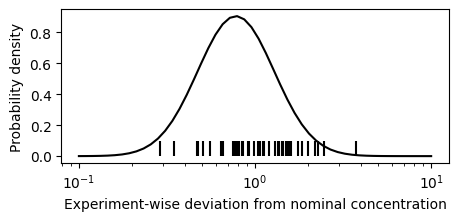

In [4]:
from scipy.stats import lognorm, norm, multinomial
import numpy as np

sigma_k = lognorm(scale=1, s=0.5)
sigma_k_vals = sigma_k.rvs(size=42, random_state=6)

fig, ax = plt.subplots(1,1, figsize=(5,2))
x_dev = np.logspace(-1, 1)
ax.plot(x_dev,sigma_k.pdf(x_dev), color="black")
ax.set_xscale("log")
ax.vlines(sigma_k_vals, 0, 0.1, color="black")
ax.set_xlabel("Experiment-wise deviation from nominal concentration")
ax.set_ylabel("Probability density")

In [5]:
sigma_k.median()

1.0

We see that a lognormal distribution with a scale parameter of 1.0 and a log-standard deviation of 0.5 has low probability of deviating from nominal concentrations of a factor of 10 or more in either direction. The median of the distribution lies at 1.0, implying that we expect to see most of the experiments correctly executed at the nominal concentrations, with some outliers above and below. 

In order to structure the between-experiment-variation over all observations, the deviation factors are mapped to the ID level by indexing each value multiple times for the respective occurences of the experiment_id in the observation matrix

In [6]:
ce_true = sim.observations.cext_nom * sigma_k_vals[sim.indices["experiment_id"]]


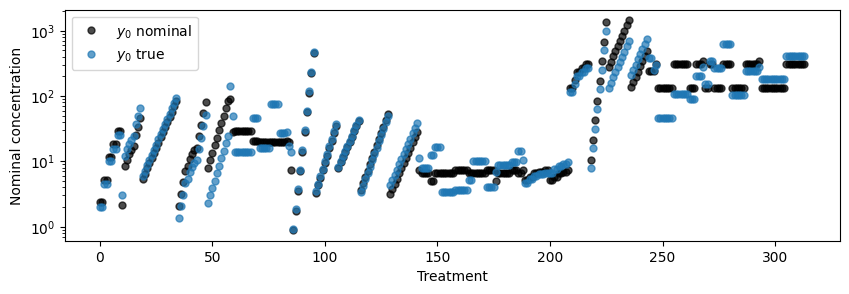

In [7]:
fig, ax = plt.subplots(1,1, figsize=(10,3))
ax.plot(ce_nom, ls="", marker="o", color="black", alpha=.7, ms=5, label="$y_0$ nominal")
ax.plot(ce_true, ls="", marker="o", color="tab:blue", alpha=.7, ms=5, label="$y_0$ true")
ax.set_yscale("log")
ax.set_ylabel("Nominal concentration")
ax.set_xlabel("Treatment")
ax.legend()

In [8]:

e = sim.dispatch(
    y0=sim.validate_model_input(ce_true.to_dataset(name="cext")),
    theta=dict(
        k_i=np.array([4.9, 0.38, 0.36])[sim.indices["substance"]],
        k_m=np.array([3.8, 0.19, 0.084])[sim.indices["substance"]],
        z_ci=np.array([1.2, 1.0, 1.2])[sim.indices["substance"]],
        ci_max=np.array([1757.0,168.1,6364.8])[sim.indices["substance"]],
        h_b=0.0,
        k_p=0.008,
        kk=0.079,
        r_rd=0.23,
        r_rt=2.3,
        v_rt=3.7,
        z=1.5,
    )
)

e()

In [9]:
e.results

<xarray.Dataset>
Dimensions:              (id: 314, time: 23)
Coordinates:
  * id                   (id) object '101_0' '101_1' '106_0' ... '77_7' '77_8'
  * time                 (time) float64 24.0 25.5 27.0 ... 114.0 117.0 120.0
    hpf                  (id) float64 24.0 24.0 24.0 24.0 ... 24.0 24.0 24.0
    nzfe                 (id) float64 nan nan nan nan ... 18.0 18.0 18.0 18.0
    treatment_id         (id) int64 101 101 106 106 112 112 ... 77 77 77 77 77
    experiment_id        (id) int64 36 36 36 36 36 36 36 ... 31 31 31 31 31 31
    substance            (id) <U10 'diuron' 'diuron' ... 'naproxen' 'naproxen'
    substance_index      (id) int64 0 0 0 0 0 0 0 0 0 0 ... 2 2 2 2 2 2 2 2 2 2
    experiment_id_index  (id) int64 0 0 0 0 0 0 0 0 ... 11 11 11 11 11 11 11 11
Data variables:
    cext                 (id, time) float32 2.002 2.002 2.002 ... 417.8 417.8
    cint                 (id, time) float32 0.0 14.71 ... 3.248e+03 3.148e+03
    nrf2                 (id, time) float32 1.0 1.035 1.06 ... 1.874 1.812 1.756
    P                    (id, time) float32 0.0 0.0002172 ... 0.6835 0.6858
    H                    (id, time) float32 0.0 0.0 0.0 0.0 ... 5.733 5.813 5.88
    survival             (id, time) float32 1.0 1.0 1.0 ... 0.002989 0.002795

In [10]:
mask = sim.observations.isnull()
mask["nzfe"] = mask.nzfe.isel(time=0)

In [11]:

sim.observations["nzfe"] = sim.observations.nzfe.isel(time=0)
sim.observations["cext"].values = e.results.cext
sim.observations["cint"].values = e.results.cint * np.exp(norm(loc=0, scale=0.1).rvs((314,23), random_state=2))
sim.observations["nrf2"].values = e.results.nrf2 * np.exp(norm(loc=0, scale=0.1).rvs((314,23), random_state=3))
# sim.observations["lethality"].values = binom(p=1-e.results.survival.clip(0,1), n=sim.observations.nzfe).rvs((314,23))
multinom_surv = (1-e.results.survival).diff(dim="time")
multinom_surv = np.column_stack([multinom_surv.values, 1-multinom_surv.sum("time")])
multinom_surv = np.clip(multinom_surv,0.000001,0.99999) 
incidence = np.array(list(map(lambda x, n: multinomial(p=x/x.sum(), n=n).rvs(), multinom_surv, sim.observations.nzfe.values) )).squeeze()
sim.observations["lethality"].values = np.column_stack([np.zeros_like(incidence[:,0]), incidence.cumsum(axis=1)[:,:-1]])

sim.observations = sim.lethality_to_conditional_survival(sim.observations)

MinMaxScaler(variable=cint, min=0.0, max=9517.493723689004)
MinMaxScaler(variable=nrf2, min=0.6215531717356583, max=13.11685186595314)
MinMaxScaler(variable=survival, min=0.0, max=20.0)


In [12]:
sim.observations

<xarray.Dataset>
Dimensions:             (id: 314, time: 23)
Coordinates:
  * time                (time) float64 24.0 25.5 27.0 30.0 ... 114.0 117.0 120.0
  * id                  (id) object '101_0' '101_1' '106_0' ... '77_7' '77_8'
    hpf                 (id) float64 24.0 24.0 24.0 24.0 ... 24.0 24.0 24.0 24.0
    nzfe                (id, time) int64 9 9 9 9 9 9 9 ... 18 18 18 18 18 18 18
    treatment_id        (id) int64 101 101 106 106 112 112 ... 77 77 77 77 77 77
    experiment_id       (id) int64 36 36 36 36 36 36 36 ... 31 31 31 31 31 31 31
    cext_nom            (id) float64 2.34 2.34 5.16 5.16 ... 309.2 309.2 309.2
    substance           (id) <U10 'diuron' 'diuron' ... 'naproxen' 'naproxen'
    substance_index     (id) int64 0 0 0 0 0 0 0 0 0 0 0 ... 2 2 2 2 2 2 2 2 2 2
    survivors_before_t  (id, time) int64 9 9 9 9 9 9 9 9 9 ... 3 2 2 1 0 0 0 0 0
Data variables:
    lethality           (id, time) int64 0 0 0 0 0 0 0 ... 17 18 18 18 18 18 18
    nrf2                (id, time) float64 1.196 1.081 1.07 ... 1.832 1.791
    cext                (id, time) float32 2.002 2.002 2.002 ... 417.8 417.8
    cint                (id, time) float64 0.0 14.63 ... 2.978e+03 3.074e+03
    survival            (id, time) int64 9 9 9 9 9 9 9 9 9 ... 2 2 1 0 0 0 0 0 0
Attributes:
    cext_diuron:           µmol L-1
    cint_diuron:           µmol L-1
    nrf2:                  fold-change
    lethality:             count
    substance:             ['diuron', 'diclofenac', 'naproxen']
    ids_subset:            
    excluded_experiments:  [999999]

### Creating the datasets and scenarios for the systematic simulation study


In [13]:
if True:
    sim.observations["nzfe"] = sim.observations.nzfe.isel(time=0)
    obs_full = sim.observations.copy()

    obs_masked = obs_full.where(~mask, np.nan)

    sim.observations = sim.lethality_to_conditional_survival(obs_masked)

MinMaxScaler(variable=cint, min=0.0, max=6592.106195300189)
MinMaxScaler(variable=nrf2, min=0.6215531717356583, max=3.806557074337876)
MinMaxScaler(variable=survival, min=0.0, max=18.0)


In [14]:
sim.dispatch_constructor()
sim.set_inferer("numpyro")

Jax 64 bit mode: False
Absolute tolerance: 1e-05


                     Trace Shapes:         
                      Param Sites:         
                     Sample Sites:         
      error_scale_normal_base dist        |
                             value        |
error_scale_sigma_normal_base dist        |
                             value        |
 sigma_experiment_normal_base dist     42 |
                             value     42 |
    k_i_substance_normal_base dist      3 |
                             value      3 |
   z_ci_substance_normal_base dist      3 |
                             value      3 |
    k_m_substance_normal_base dist      3 |
                             value      3 |
             r_rt_normal_base dist        |
                             value        |
             r_rd_normal_base dist        |
                             value        |
             v_rt_normal_base dist        |
                             value        |
              k_p_normal_base dist        |
                             val

100%|██████████| 500/500 [00:31<00:00, 15.67it/s, init loss: 9506.9336, avg. loss [476-500]: -447.4202]
/home/flo-schu/miniconda3/envs/molecular-tktd/lib/python3.11/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/flo-schu/miniconda3/envs/molecular-tktd/lib/python3.11/site-packages/numpy/core/_methods.py:258: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/flo-schu/miniconda3/envs/molecular-tktd/lib/python3.11/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/flo-schu/miniconda3/envs/molecular-tktd/lib/python3.11/site-packages/numpy/core/_methods.py:258: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/flo-schu/miniconda3/envs/molecular-tktd/lib/python3.11/site-packages/numpy/core/_methods.py:269: RuntimeWa

                              mean  sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
cext_y0[101_0]               2.199 NaN   2.199    2.199        NaN      NaN   
cext_y0[101_1]               2.199 NaN   2.199    2.199        NaN      NaN   
cext_y0[106_0]               4.848 NaN   4.848    4.848        NaN      NaN   
cext_y0[106_1]               4.848 NaN   4.848    4.848        NaN      NaN   
cext_y0[112_0]              11.012 NaN  11.012   11.012        NaN      NaN   
...                            ...  ..     ...      ...        ...      ...   
z_ci[77_7]                   1.373 NaN   1.373    1.373        NaN      NaN   
z_ci[77_8]                   1.373 NaN   1.373    1.373        NaN      NaN   
z_ci_substance[diuron]       1.392 NaN   1.392    1.392        NaN      NaN   
z_ci_substance[diclofenac]   1.129 NaN   1.129    1.129        NaN      NaN   
z_ci_substance[naproxen]     1.373 NaN   1.373    1.373        NaN      NaN   

                            ess_bulk  ess_tail  r_h

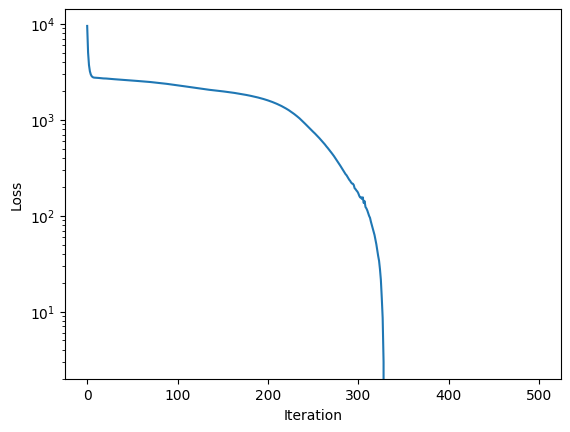

In [15]:
sim.config.inference_numpyro.svi_iterations = 500
sim.config.inference_numpyro.svi_learning_rate = 0.005
sim.config.inference_numpyro.kernel = "map"
sim.config.simulation.seed=2
sim.inferer.run()
sim.inferer.store_results()

/home/flo-schu/miniconda3/envs/molecular-tktd/lib/python3.11/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/flo-schu/miniconda3/envs/molecular-tktd/lib/python3.11/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/home/flo-schu/miniconda3/envs/molecular-tktd/lib/python3.11/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/flo-schu/miniconda3/envs/molecular-tktd/lib/python3.11/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/home/flo-schu/miniconda3/envs/molecular-tktd/lib/python3.11/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtyp

PRETTY PLOT: starting...
PRETTY PLOT: make predictions for Diuron in bin (1/5)
PRETTY PLOT: make predictions for Diuron in bin (2/5)
PRETTY PLOT: make predictions for Diuron in bin (3/5)
PRETTY PLOT: make predictions for Diuron in bin (4/5)
PRETTY PLOT: make predictions for Diuron in bin (5/5)
PRETTY PLOT: make predictions for Diclofenac in bin (1/4)
PRETTY PLOT: make predictions for Diclofenac in bin (2/4)
PRETTY PLOT: make predictions for Diclofenac in bin (3/4)
PRETTY PLOT: make predictions for Diclofenac in bin (4/4)
PRETTY PLOT: make predictions for Naproxen in bin (1/6)
PRETTY PLOT: make predictions for Naproxen in bin (2/6)
PRETTY PLOT: make predictions for Naproxen in bin (3/6)
PRETTY PLOT: make predictions for Naproxen in bin (4/6)
PRETTY PLOT: make predictions for Naproxen in bin (5/6)
PRETTY PLOT: make predictions for Naproxen in bin (6/6)


TypeError: Axes.vlines() takes from 4 to 7 positional arguments but 316 were given

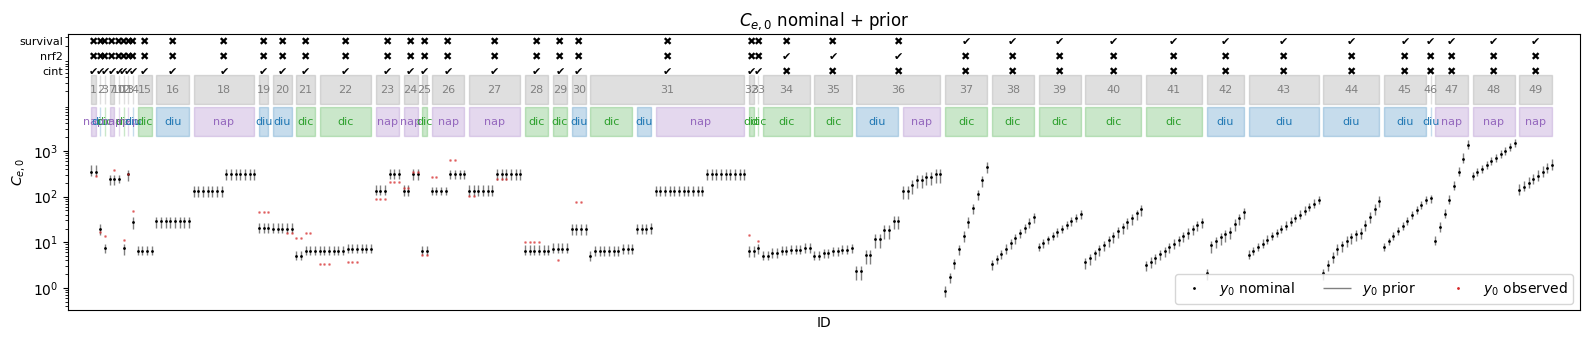

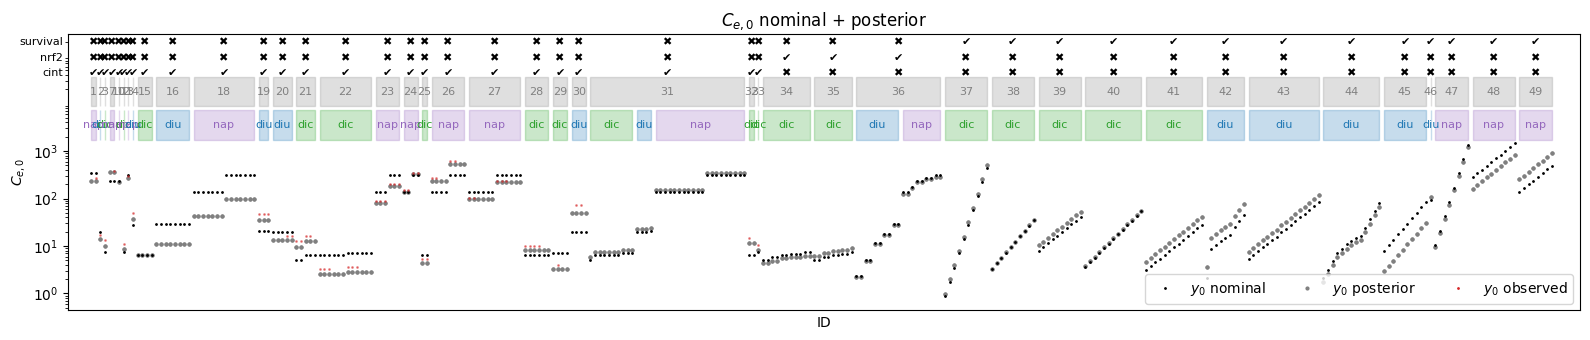

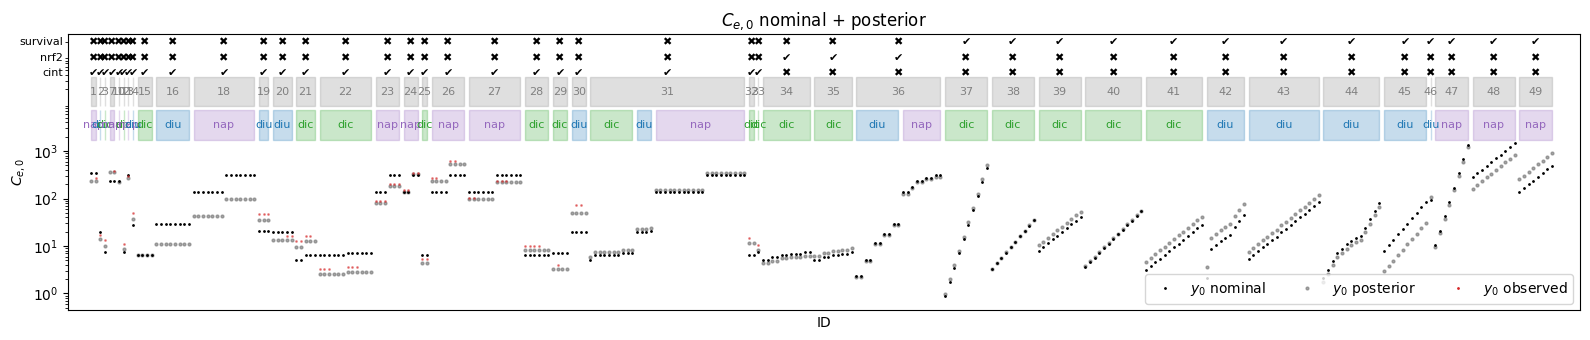

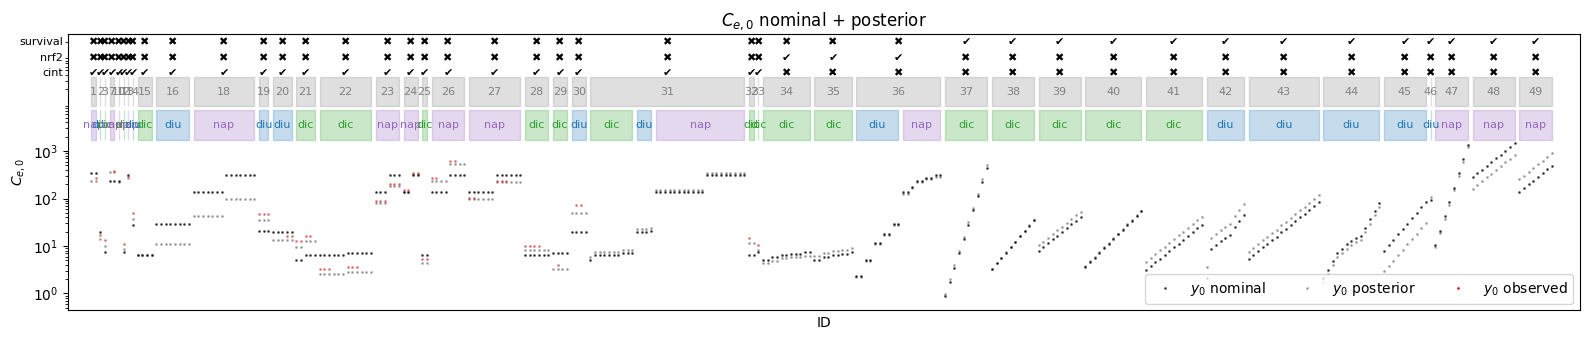

In [19]:
sim.config.report.debug_report = True
sim.report()

/home/flo-schu/projects/pymob/pymob/inference/numpyro_backend.py:685: UserWarning: Discouraged use of inferer.posterior APIuse inferer.idata.posterior instead.
  warnings.warn(


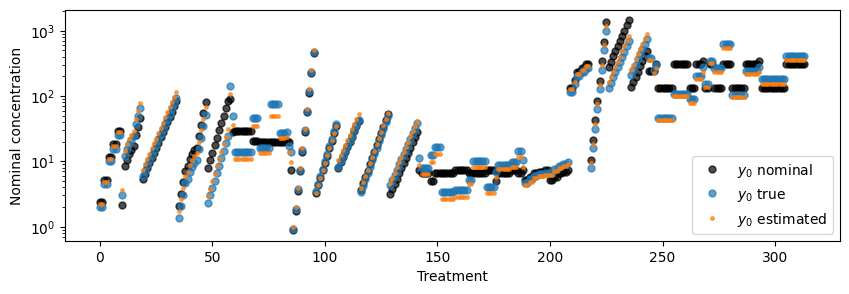

In [17]:
ce_esti = sim.inferer.posterior.cext_y0.mean(("chain", "draw"))
fig, ax = plt.subplots(1,1, figsize=(10,3))
ax.plot(ce_nom, ls="", marker="o", color="black", alpha=.7, ms=5, label="$y_0$ nominal")
ax.plot(ce_true, ls="", marker="o", color="tab:blue", alpha=.7, ms=5, label="$y_0$ true")
ax.plot(ce_esti, ls="", marker="o", color="tab:orange", alpha=.7, ms=2.5, label="$y_0$ estimated")

ax.set_yscale("log")
ax.set_ylabel("Nominal concentration")
ax.set_xlabel("Treatment")
ax.legend()
